In [31]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [79]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import datetime as dt
import math as mt
from pymongo import MongoClient as mc
import IPython
import IPython.display
from sklearn.decomposition import TruncatedSVD 
from scipy.spatial import distance
import scipy.stats
from modules.models import *
from modules.utils import *

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

mongo_uri = "mongodb://localhost:27017"
mongoClient = mc(mongo_uri)
proto_col = mongoClient.reco_contract.prototype

In [33]:
# 1. read datas.xlsx
xlsx = load_excel("datas/datas.xlsx")

# 2. data pre-processing
p, m = data_preprocessing(xlsx)

In [34]:
month_datas_df = m.set_index("month").copy()

month = 1
month_usage_df = pd.DataFrame(columns=['name', 'usage (kWh)'])

for name in month_datas_df:
    kwh = month_datas_df.loc[month][name]
    month_usage_df = month_usage_df.append({
        "name": name,
        "usage (kWh)": kwh
    }, ignore_index=True)
    
month_usage_df

,name,usage (kWh)
0,아파트1-101-1002,253
1,아파트1-101-104,689
2,아파트1-101-1102,183
3,아파트1-101-1202,239
4,아파트1-101-1302,455
...,...,...
393,아파트4-105-103,518
394,아파트4-105-1102,230
395,아파트4-105-1104,279
396,아파트4-105-601,161


### 1. 데이터에 변화를 주지 않은 상태에서 진행

In [62]:
month_idx = 0
month_datas_df = pd.DataFrame(m.iloc[month_idx]).T

In [63]:
month_datas_df.reset_index()

min_per = 10
max_per = 80

result = bill_calc(month_datas_df, p, min_per, max_per)

1


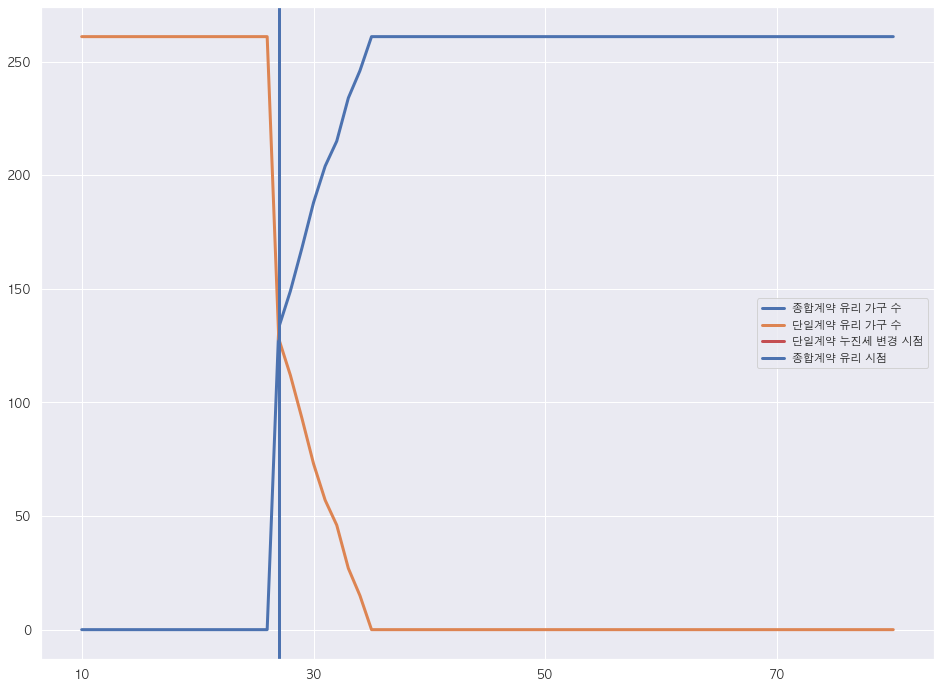

In [647]:
main_target = 'better'
c, s = result[main_target]['comp'], result[main_target]['single'] 
plt.figure(figsize=(16, 12))

chk = 0
for idx,c_val in enumerate(c.iloc[month_idx]):
    if c_val > s.iloc[month_idx][idx]:
        chk = min_per + idx
        break

plt.plot(range(min_per, max_per + 1), c.iloc[month_idx], label="종합계약 유리 가구 수", linewidth=3)
plt.plot(range(min_per, max_per + 1), s.iloc[month_idx], label="단일계약 유리 가구 수", linewidth=3)
for ch in per_change_step:
    plt.axvline(ch, label="단일계약 누진세 변경 시점", color="r", linewidth=3)
plt.axvline(chk, label="종합계약 유리 시점", color="b", linewidth=3)

plt.xticks(range(min_per, max_per + 1, 20))
plt.legend()
plt.show()

In [648]:
pd.DataFrame([{
    "공동설비사용량": "{}%".format(chk),
    "계약종류": "종합계약",
    "유리 가구 수": int(c[str(chk)])
}, {
    "공동설비사용량": "{}%".format(chk),
    "계약종류": "단일계약",
    "유리 가구 수": int(s[str(chk)])
}])

,공동설비사용량,계약종류,유리 가구 수
0,27%,종합계약,133
1,27%,단일계약,128


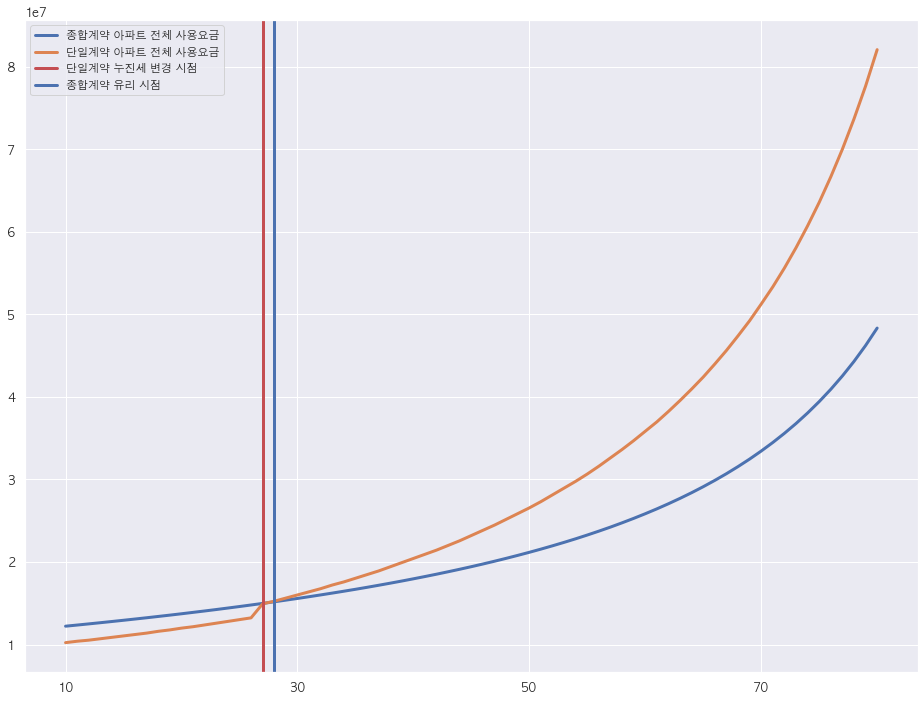

In [649]:
main_target = 'bill'
c, s = result[main_target]['comp'], result[main_target]['single'] 
plt.figure(figsize=(16, 12))

chk = 0
for idx,c_val in enumerate(c.iloc[month_idx]):
    if c_val < s.iloc[month_idx][idx]:
        chk = min_per + idx
        break

plt.plot(range(min_per, max_per + 1), c.iloc[month_idx], label="종합계약 아파트 전체 사용요금", linewidth=3)
plt.plot(range(min_per, max_per + 1), s.iloc[month_idx], label="단일계약 아파트 전체 사용요금", linewidth=3)
for ch in per_change_step:
    plt.axvline(ch, label="단일계약 누진세 변경 시점", color="r", linewidth=3)
plt.axvline(chk, label="종합계약 유리 시점", color="b", linewidth=3)

plt.xticks(range(min_per, max_per + 1, 20))
plt.legend()
plt.show()

In [650]:
pd.DataFrame([{
    "공동설비사용량": "{}%".format(chk),
    "계약종류": "종합계약",
    "아파트 전체 사용요금": "{}원".format(format(int(c[str(chk)]), ','))
}, {
    "공동설비사용량": "{}%".format(chk),
    "계약종류": "단일계약",
    "아파트 전체 사용요금": "{}원".format(format(int(s[str(chk)]), ','))
}])

,공동설비사용량,계약종류,아파트 전체 사용요금
0,28%,종합계약,"15,175,520원"
1,28%,단일계약,"15,246,180원"


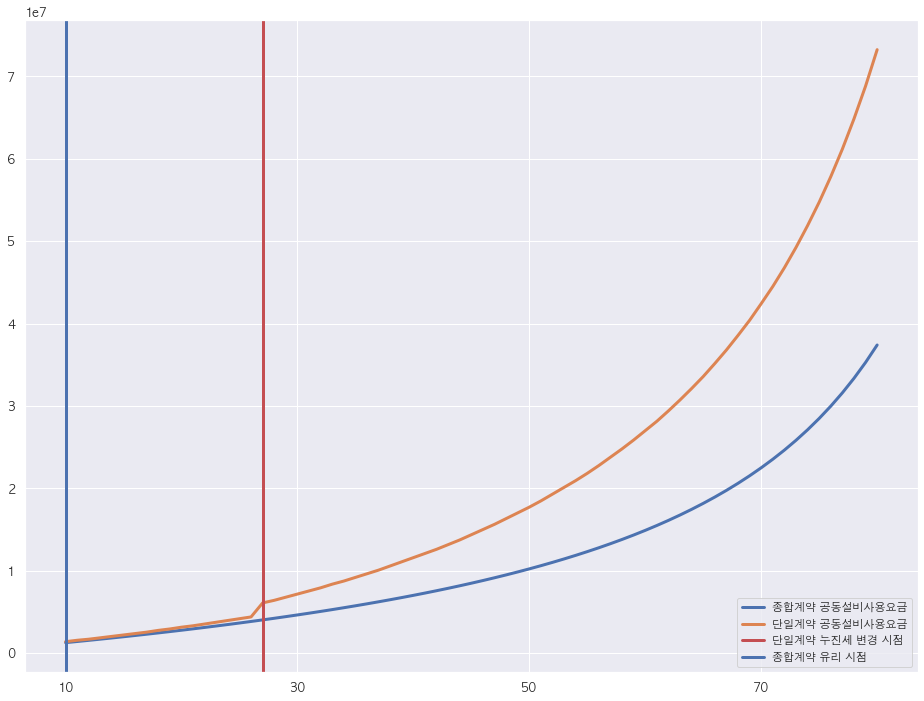

In [651]:
main_target = 'public_bill'
c, s = result[main_target]['comp'], result[main_target]['single'] 
plt.figure(figsize=(16, 12))

chk = 0
for idx,c_val in enumerate(c.iloc[month_idx]):
    if c_val < s.iloc[month_idx][idx]:
        chk = min_per + idx
        break

plt.plot(range(min_per, max_per + 1), c.iloc[month_idx], label="종합계약 공동설비사용요금", linewidth=3)
plt.plot(range(min_per, max_per + 1), s.iloc[month_idx], label="단일계약 공동설비사용요금", linewidth=3)
for ch in per_change_step:
    plt.axvline(ch, label="단일계약 누진세 변경 시점", color="r", linewidth=3)
plt.axvline(chk, label="종합계약 유리 시점", color="b", linewidth=3)

plt.xticks(range(min_per, max_per + 1, 20))
plt.legend()
plt.show()

In [652]:
pd.DataFrame([{
    "공동설비사용량": "{}%".format(chk),
    "계약종류": "종합계약",
    "공동설비사용요금": "{}원".format(format(int(c[str(chk)]), ','))
}, {
    "공동설비사용량": "{}%".format(chk),
    "계약종류": "단일계약",
    "공동설비사용요금": "{}원".format(format(int(s[str(chk)]), ','))
}])

,공동설비사용량,계약종류,공동설비사용요금
0,10%,종합계약,"1,264,570원"
1,10%,단일계약,"1,381,950원"


In [653]:
month_datas_df = m.set_index("month").copy()

month = 1
month_usage_df = pd.DataFrame(columns=['name', 'usage (kWh)'])

for name in month_datas_df:
    kwh = month_datas_df.loc[month][name]
    month_usage_df = month_usage_df.append({
        "name": name,
        "usage (kWh)": kwh
    }, ignore_index=True)
    
in_m = pd.DataFrame()
in_m['month'] = [month]
# 변화 안줌
# step_1_df = month_usage_df
# step_1_df = month_usage_df[month_usage_df['usage (kWh)'] <= 200]
# step_1_df = month_usage_df[(month_usage_df['usage (kWh)'] <= 400) & (month_usage_df['usage (kWh)'] >= 201)]
step_1_df = month_usage_df[(month_usage_df['usage (kWh)'] >= 401)]
# step_1_df = month_usage_df[(month_usage_df['usage (kWh)'] >= 401) | (month_usage_df['usage (kWh)'] <= 200)]
# step_1_df = month_usage_df[((month_usage_df['usage (kWh)'] <= 400) & (month_usage_df['usage (kWh)'] >= 201)) | (month_usage_df['usage (kWh)'] <= 200)]
# step_1_df = month_usage_df[((month_usage_df['usage (kWh)'] <= 400) & (month_usage_df['usage (kWh)'] >= 201)) | (month_usage_df['usage (kWh)'] >= 401)]

# step_1_df = step_1_df[:round(len(step_1_df) / 2)]
for idx in step_1_df.index:
    name = step_1_df.loc[idx]['name']
    kwh = step_1_df.loc[idx]['usage (kWh)']
    in_m[name] = [kwh]
    
in_m

,month,아파트1-101-104,아파트1-101-1302,아파트1-101-503,아파트1-101-704,아파트1-102-1402,아파트1-102-301,아파트1-102-403,아파트1-102-404,아파트1-102-802,...,아파트4-103-1307,아파트4-103-1404,아파트4-103-410,아파트4-103-706,아파트4-103-708,아파트4-103-805,아파트4-103-902,아파트4-103-906,아파트4-103-910,아파트4-105-103
0,1,689,455,422,473,463,416,424,436,406,...,448,442,569,407,475,447,490,446,434,518


In [654]:
print(round(in_m.drop('month', axis=1).count(axis=1)))
print(round(in_m.drop('month', axis=1).std(axis=1)))
print(round(in_m.drop('month', axis=1).mean(axis=1)))

0    48
dtype: int64
0    76.0
dtype: float64
0    469.0
dtype: float64


In [655]:
min_per = 10
max_per = 80

result = bill_calc(in_m, p, min_per, max_per)
APTs = np.round(result['information']['apts'] / round(in_m.drop('month', axis=1).count(axis=1))[0])
steps = [0, 201, 401]
init_step = 0

for idx in range(0, len(steps) - 1):
    if APTs[0] < steps[idx + 1]:
        init_step = idx
        break
        
# 누진 변화 구간 체크
change_step = np.array([])
for idx,APT in enumerate(APTs):
    if init_step >= (len(steps) - 1):
            break
            
    if APT >= steps[init_step + 1]:
        change_step = np.append(change_step,idx)
        init_step += 1

change_step
per_change_step = change_step + min_per

print(change_step)
print(per_change_step)

1
[0. 1.]
[10. 11.]


In [656]:
APTs

array([ 521.,  526.,  532.,  539.,  545.,  551.,  558.,  564.,  571.,
        578.,  586.,  593.,  601.,  608.,  616.,  625.,  633.,  642.,
        651.,  660.,  669.,  679.,  689.,  699.,  710.,  721.,  732.,
        744.,  756.,  768.,  781.,  794.,  808.,  822.,  837.,  852.,
        868.,  884.,  901.,  919.,  937.,  956.,  976.,  997., 1019.,
       1041., 1065., 1090., 1116., 1143., 1171., 1201., 1233., 1266.,
       1302., 1339., 1378., 1420., 1464., 1511., 1562., 1616., 1673.,
       1735., 1802., 1874., 1952., 2037., 2130., 2231., 2343.])

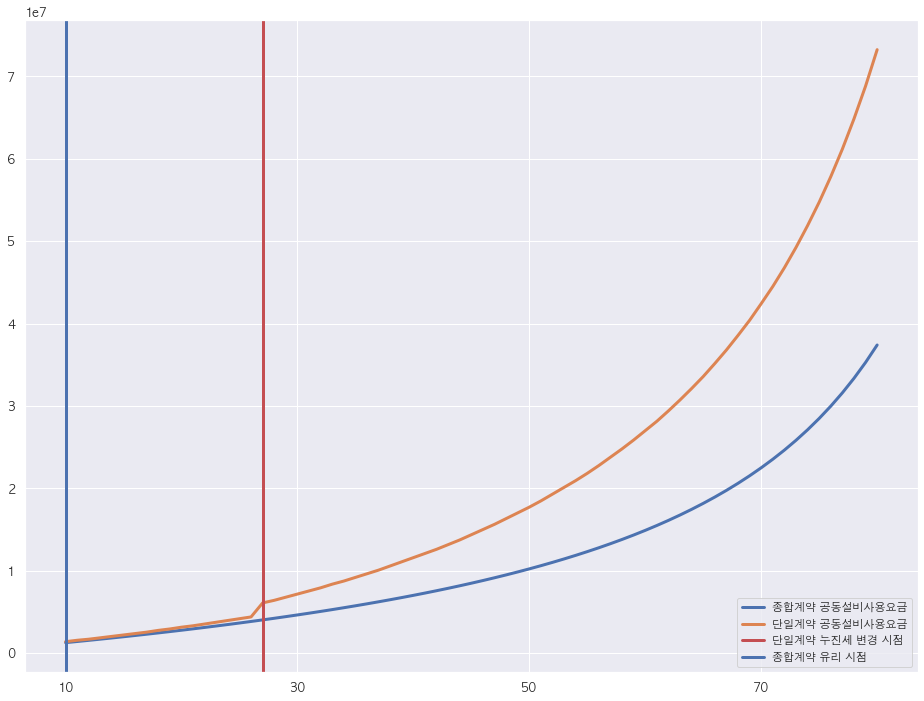

In [646]:
main_target = 'public_bill'
c, s = result[main_target]['comp'], result[main_target]['single'] 
plt.figure(figsize=(16, 12))

chk = 0
for idx,c_val in enumerate(c.iloc[month_idx]):
    if c_val < s.iloc[month_idx][idx]:
        chk = min_per + idx
        break

plt.plot(range(min_per, max_per + 1), c.iloc[month_idx], label="종합계약 공동설비사용요금", linewidth=3)
plt.plot(range(min_per, max_per + 1), s.iloc[month_idx], label="단일계약 공동설비사용요금", linewidth=3)
for ch in per_change_step:
    plt.axvline(ch, label="단일계약 누진세 변경 시점", color="r", linewidth=3)
plt.axvline(chk, label="종합계약 유리 시점", color="b", linewidth=3)

plt.xticks(range(min_per, max_per + 1, 20))
plt.legend()
plt.show()

In [613]:
pd.DataFrame([{
    "공동설비사용량": "{}%".format(chk),
    "계약종류": "종합계약",
    "공동설비사용요금": "{}원".format(format(int(c[str(chk)]), ','))
}, {
    "공동설비사용량": "{}%".format(chk),
    "계약종류": "단일계약",
    "공동설비사용요금": "{}원".format(format(int(s[str(chk)]), ','))
}])

,공동설비사용량,계약종류,공동설비사용요금
0,17%,종합계약,"3,128,680원"
1,17%,단일계약,"3,169,760원"
